# Assignment 5

**Aim of this Assignment**
1. Find 50 misclassified images from your Session 4 submission model
2. Run GradCam (http://www.hackevolve.com/where-cnn-is-looking-grad-cam/) on these images
3. Create a gallery of your GradCam results
4. Upload your Colab file to a public github repo, and
5. Upload your GitHub Link here: https://tinyurl.com/yxt6x2qq (https://tinyurl.com/yxt6x2qq)
6. You need to attempt this quiz before the next session starts: https://tinyurl.com/y2t2ux8z (https://tinyurl.com/y2t2ux8z)

## Input Data Handling

In [0]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(1017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
# import chainer ## added from https://github.com/corochann/deep-learning-tutorial-with-chainer/blob/master/src/04_cifar_cnn/cifar10_cifar100_dataset_introduction.ipynb
from keras.layers import MaxPooling2D, SpatialDropout2D, Dropout


In [3]:

!pip install --upgrade --upgrade-strategy only-if-needed https://github.com/amitkayal/data-science-utils/tarball/master > /dev/null
!pip install git+https://www.github.com/keras-team/keras-contrib.git > /dev/null
!pip install keract > /dev/null

  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-yn5t5v17


In [0]:
# !pip install scipy==1.1.0  ## This is required to downgrade to use imresize


In [0]:
from keras.preprocessing import image
from keras.layers import Input, Dense
from keras.models import Model

from data_science_utils.vision.keras import *
from data_science_utils import misc

# from skimage.transform import resize

# # with warnings.catch_warnings():
# #     warnings.simplefilter("ignore", category=DeprecationWarning)
# def warn(*args, **kwargs):
#     pass
# import warnings
# warnings.warn = warn

# from scipy.misc import toimage, imresize
# from skimage.transform import resize

In [6]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 2s 0us/step


Text(0.5, 1.0, 'airplane')

Text(0.5, 1.0, 'automobile')

Text(0.5, 1.0, 'bird')

Text(0.5, 1.0, 'cat')

Text(0.5, 1.0, 'deer')

Text(0.5, 1.0, 'dog')

Text(0.5, 1.0, 'frog')

Text(0.5, 1.0, 'horse')

Text(0.5, 1.0, 'ship')

Text(0.5, 1.0, 'truck')

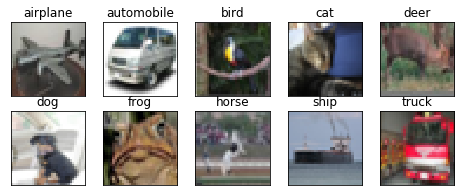

In [0]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
X_train, Y_train, X_test, Y_test = get_cifar10_data()


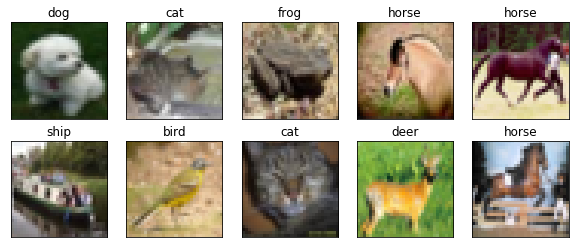

In [0]:
show_examples(X_train[1920:1930], Y_train[1920:1930], classes = get_cifar10_labels())

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255

# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

##  Required Functions

### Dataset Analysis

CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class.

### Network analysis

In [0]:
def SaveFileGoogleDrive(FileName):
  from pydrive.auth import GoogleAuth
  from pydrive.drive import GoogleDrive
  from google.colab import auth
  from oauth2client.client import GoogleCredentials
  ## Following 2 lines there as per https://stackoverflow.com/questions/55443061/installing-google-appengine-on-google-colab-notebook

  import logging
  logging.getLogger('googleapiclient.discovery_cache').setLevel(logging.ERROR)
  # 1. Authenticate and create the PyDrive client.
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default() 
  drive = GoogleDrive(gauth)

  folder_id = '1gHWgHdaFfpQanZzXHrBPP9uct_albh19'

  file = drive.CreateFile({'parents':[{u'id': folder_id}]})
  file.SetContentFile(FileName)
  file.Upload()

In [0]:
## https://github.com/durandtibo/heatmap

import matplotlib.pyplot as plt
import numpy as np
from skimage import transform

# save = os.path('/content/gdrive/My Drive/ModelWeightsBackup/image_superimposed.jpeg')
def add(image, heat_map, alpha=0.6, display=False, save=None, cmap='viridis', axis='on', verbose=False):

    height = image.shape[0]
    width = image.shape[1]

    # resize heat map
    heat_map_resized = transform.resize(heat_map, (height, width))

    # normalize heat map
    max_value = np.max(heat_map_resized)
    min_value = np.min(heat_map_resized)
    normalized_heat_map = (heat_map_resized - min_value) / (max_value - min_value)

    # display
    plt.imshow(image)
    plt.imshow(255 * normalized_heat_map, alpha=alpha, cmap=cmap)
    plt.axis(axis)

    if display:
        plt.show()
    return image

#     if save is not None:
#         if verbose:
#             print('save image: ' + save)
# plt.savefig(save, bbox_inches='tight', pad_inches=0)

In [0]:
from keras import initializers
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import LSTM, Input, TimeDistributed,Convolution2D,Activation
from keras.layers.convolutional import ZeroPadding2D
from keras.optimizers import RMSprop, SGD
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras import optimizers
from keras.preprocessing import sequence
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import load_model

from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from keras.callbacks import *

from keras.layers import Concatenate
from keras.layers import advanced_activations
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils.np_utils import to_categorical
from keras.optimizers import SGD
from matplotlib import pyplot as plt   
from keras.datasets import mnist
from keras.utils import np_utils
from keras.models import load_model
from keras import regularizers
import cv2
#FinalModel.add(modelNew)
from keras import regularizers
from keras import layers

# Import the backend

from keras.layers import Concatenate
from keras.layers import advanced_activations


import os
from keras.callbacks import *
from sklearn.model_selection import train_test_split
###
import glob
import matplotlib.pyplot as plt
import random
import scipy.ndimage
import tensorflow as tf

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
import zipfile
import shutil
import linecache
import os
import sys
from tqdm import tqdm
import random

from collections import Counter
from six.moves.urllib.request import urlretrieve

from IPython.core.interactiveshell import InteractiveShell
# pretty print all cell's output and not just the last one
InteractiveShell.ast_node_interactivity = "all"

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn import preprocessing
from keras.preprocessing.image import ImageDataGenerator
import datetime
import pandas as pd

# Model Development

https://github.com/qubvel/classification_models

## Initial Model

In [0]:
# !git clone https://github.com/qubvel/classification_models.git
# !ls -ltr
# !pwd
# import os
# os.chdir('/content/classification_models')

# from random_eraser import get_random_eraser
# !cd

In [8]:
!pip install image-classifiers
!pip install git+https://github.com/qubvel/classification_models.git

     |████████████████████████████████| 81kB 3.9MB/s 
  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-w3ngiiql
  Running command git clone -q https://github.com/qubvel/classification_models.git /tmp/pip-req-build-w3ngiiql
  Running command git submodule update --init --recursive -q
  Stored in directory: /tmp/pip-ephem-wheel-cache-vh273r6s/wheels/de/2b/fd/29a6d33edb8c28bc7d94e95ea1d39c9a218ac500a3cfb1b197
Successfully built image-classifiers


In [0]:
import numpy as np
from skimage.io import imread
from skimage.transform import resize
from keras.applications.imagenet_utils import decode_predictions

from classification_models.resnet import ResNet18, preprocess_input

In [12]:
import keras
from keras.preprocessing import image
import numpy as np
from keras.layers import Layer
import datetime

n_classes = 10

modelEIP3P2_Assignment5 = ResNet18(input_shape=(32,32,3), weights='imagenet', classes=10, include_top=False)  ## ResNet50(weights='imagenet')

modelEIP3P2_x = keras.layers.GlobalAveragePooling2D()(modelEIP3P2_Assignment5.output)
modelEIP3P2_output = keras.layers.Dense(n_classes, activation='softmax')(modelEIP3P2_x)
modelEIP3P2_model = keras.models.Model(inputs=[modelEIP3P2_Assignment5.input], outputs=[modelEIP3P2_output])
modelEIP3P2_model.summary()

# img_path = 'elephant.jpg'
# img = image.load_img(img_path, target_size=(224, 224))
# x = image.img_to_array(img)
# x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)

# preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
# print('Predicted:', decode_predictions(preds, top=3)[0])
# Predicted: [(u'n02504013', u'Indian_elephant', 0.82658225), (u'n01871265', u'tusker', 0.1122357), (u'n02504458', u'African_elephant', 0.061040461)]
currentDT = datetime.datetime.now()
print("Current time:", currentDT)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 32, 32, 3)    9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_37 (ZeroPadding2 (None, 38, 38, 3)    0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 16, 16, 64)   9408        zero_padding2d_37[0][0]          
__________________________________________________________________________________________________
bn0 (Batch

In [0]:
# for layer in model.layers[:-5]:
#     layer.trainable = False

In [16]:
modelEIP3P2_model.compile(loss='categorical_crossentropy',
#                 optimizer=sgd,
                optimizer=SGD(lr=0.002,momentum=0.9),
                metrics=['accuracy'])

# modelCiphar.summary()

currentDT = datetime.datetime.now()
print("Current time:", currentDT)

W0708 11:05:31.974531 140512081962880 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



Current time: 2019-07-08 11:05:31.999981


In [0]:
def get_model_memory_usage(batch_size, model):
    import numpy as np
    from keras import backend as K

    shapes_mem_count = 0
    for l in model.layers:
        single_layer_mem = 1
        for s in l.output_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = np.sum([K.count_params(p) for p in set(model.trainable_weights)])
    non_trainable_count = np.sum([K.count_params(p) for p in set(model.non_trainable_weights)])

    total_memory = 4.0*batch_size*(shapes_mem_count + trainable_count + non_trainable_count)
    gbytes = np.round(total_memory / (1024.0 ** 3), 3)
    return gbytes
  
print("Memory usage (GB):BS64", get_model_memory_usage(64,modelEIP3P2_model))
print("Memory usage (GB):BS128", get_model_memory_usage(128,modelEIP3P2_model))

Memory usage (GB):BS64 2.737
Memory usage (GB):BS128 5.475


In [0]:
from keras.utils import plot_model
plot_model(modelEIP3P2_model, to_file='model_eip_assignment5.png')
currentDT = datetime.datetime.now()
print("Current time:", currentDT)

Current time: 2019-07-02 07:03:30.727964


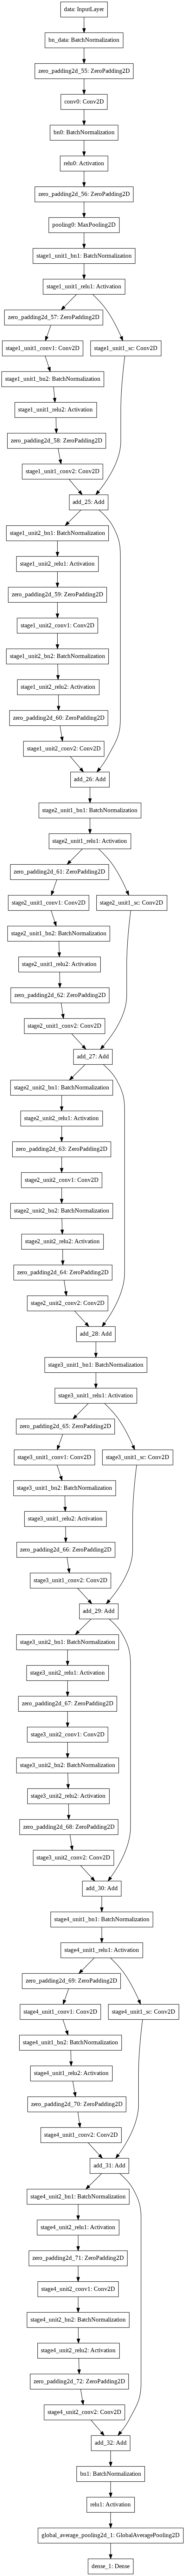

Current time: 2019-07-02 07:03:32.230712


In [0]:
from IPython.display import Image
Image(filename='model_eip_assignment5.png')
currentDT = datetime.datetime.now()
print("Current time:", currentDT)

## Model Parameter Set and Execution

In [0]:
datagen_samplewise_mean_norm = ImageDataGenerator()
currentDT = datetime.datetime.now()
print("Current time:", currentDT)

Current time: 2019-07-02 07:03:40.521699


In [0]:
# currentDT = datetime.datetime.now()
# print("Current time:", currentDT)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.15,
#                               mode = 'auto', cooldown = 3, patience=1, min_lr=0.1, verbose=1)

Current time: 2019-06-26 04:36:14.638447


In [0]:
datagen_samplewise_mean_norm.fit(train_features)
datagen_samplewise_mean_norm.fit(test_features)
currentDT = datetime.datetime.now()
print("Current time:", currentDT)

Current time: 2019-07-02 07:03:44.081365


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

currentDT = datetime.datetime.now()
print("Current time:", currentDT)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
Current time: 2019-07-02 13:53:51.353606


Here model weight file path is being given to my gogle drive path and hence model weight will be saved through call back function. I have used reduced lerning rate function from keras through callback function and monitored metrice is being set to validation loss.

In [0]:
filepath='/content/gdrive/My Drive/ModelWeightsBackup/EIP3.0_Assignment5.hdf5'

currentDT = datetime.datetime.now()
print("Current time:", currentDT)

callbackscustom = [ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True,period=1)]


modelEIP3P2_modelDetails = modelEIP3P2_model.fit(x=train_features, y=train_labels,
                             batch_size=64,
                             epochs=50,
                             verbose=1,
                             shuffle=False,
                             callbacks=callbackscustom,
#                            validation_data=(X_val, Y_val)
                             validation_data=(test_features, test_labels)
                             ) 
currentDT = datetime.datetime.now()
print("Current time:", currentDT)

W0702 07:05:58.782678 140486927316864 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Current time: 2019-07-02 07:05:58.641199
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 65s 1ms/step - loss: 0.9631 - acc: 0.6695 - val_loss: 0.7398 - val_acc: 0.7441

Epoch 00001: val_acc improved from -inf to 0.74410, saving model to /content/gdrive/My Drive/ModelWeightsBackup/EIP3.0_Assignment5.hdf5
Epoch 2/50
50000/50000 [==============================] - 59s 1ms/step - loss: 0.5212 - acc: 0.8222 - val_loss: 0.7081 - val_acc: 0.7637

Epoch 00002: val_acc improved from 0.74410 to 0.76370, saving model to /content/gdrive/My Drive/ModelWeightsBackup/EIP3.0_Assignment5.hdf5
Epoch 3/50
50000/50000 [==============================] - 59s 1ms/step - loss: 0.2909 - acc: 0.9063 - val_loss: 0.7806 - val_acc: 0.7706

Epoch 00003: val_acc improved from 0.76370 to 0.77060, saving model to /content/gdrive/My Drive/ModelWeightsBackup/EIP3.0_Assignment5.hdf5
Epoch 4/50
50000/50000 [==============================] - 59s 1ms/step - loss: 0.

In [0]:
modelEIP3P2_model.load_weights('/content/gdrive/My Drive/ModelWeightsBackup/EIP3.0_Assignment5.hdf5')
currentDT = datetime.datetime.now()
print("Current time:", currentDT)

Current time: 2019-07-02 13:54:06.203504


## Model Testing and Confusion Matrix Analysis

Have loaded best weight of the model to ensure we can execute with same model condition

In [0]:
final_loss, final_acc = modelEIP3P2_model.evaluate(test_features, test_labels, verbose=1)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))
currentDT = datetime.datetime.now()
print("Current time:", currentDT)

10000/10000 [==============================] - 6s 600us/step
Final loss: 1.276541, final accuracy: 0.809900
Current time: 2019-07-02 13:54:18.119387


In [0]:
from sklearn.metrics import accuracy_score #works
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
# import for showing the confusion matrix
import itertools


def show_classification_matrix(Y_pred,test_labels):
  # Convert predictions classes to one hot vectors 
  Y_pred_classes = np.argmax(Y_pred,axis = 1)
  # Convert validation observations to one hot vectors
  Y_true = np.argmax(test_labels,axis = 1) 
  # # compute the confusion matrix
  print("Confusion matrix:\n%s" % confusion_matrix(y_true=Y_true, y_pred=Y_pred_classes))
  # compute the confusion matrix
  confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
  return confusion_mtx


Following function has been used here to generate confusion matrix. Thjos is key for model prediction analysis and depending on this outcome from confusion matrix, we can do further image augmentation or add model weightage based on class to further improve the accuracy.

In [0]:
Y_pred = modelEIP3P2_model.predict(test_features)
CFMatrix = show_classification_matrix(Y_pred,test_labels)
currentDT = datetime.datetime.now()
print("Current time:", currentDT)

Confusion matrix:
[[845  14  27   8  21   5   6   8  43  23]
 [ 12 885   1   7   0   7   8   2  15  63]
 [ 46   3 743  35  69  36  41  19   4   4]
 [ 12   4  46 637  56 143  48  40   7   7]
 [ 15   4  42  30 807  20  35  43   3   1]
 [ 11   3  28 157  36 696  19  46   2   2]
 [  5   3  27  45  20  15 877   3   2   3]
 [ 10   3  20  24  46  40   1 838   3  15]
 [ 34  18   9   8   6   4   5   3 896  17]
 [ 19  58   4   7   4   5   3   5  20 875]]
Current time: 2019-07-02 14:02:32.407262


In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

<Figure size 720x432 with 0 Axes>

Confusion matrix, without normalization
[[845  14  27   8  21   5   6   8  43  23]
 [ 12 885   1   7   0   7   8   2  15  63]
 [ 46   3 743  35  69  36  41  19   4   4]
 [ 12   4  46 637  56 143  48  40   7   7]
 [ 15   4  42  30 807  20  35  43   3   1]
 [ 11   3  28 157  36 696  19  46   2   2]
 [  5   3  27  45  20  15 877   3   2   3]
 [ 10   3  20  24  46  40   1 838   3  15]
 [ 34  18   9   8   6   4   5   3 896  17]
 [ 19  58   4   7   4   5   3   5  20 875]]


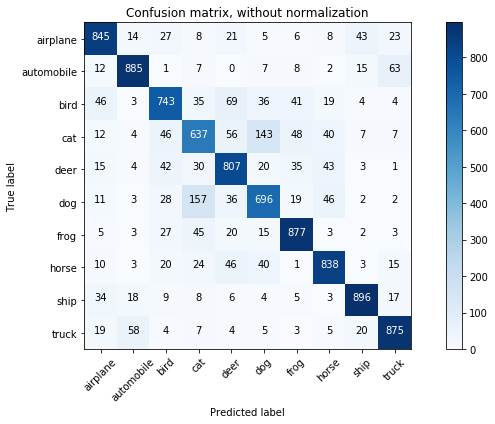

In [0]:
# Names of predicted classes
class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(CFMatrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.show()

In [0]:
# modelCiphareNAS.load_weights('weights-assignment_9.hdf5')

In [0]:
#   !pip install pydrive
#   from pydrive.auth import GoogleAuth
#   from pydrive.drive import GoogleDrive
#   from google.colab import auth
#   from oauth2client.client import GoogleCredentials
#   currentDT = datetime.datetime.now()
#   print("Current time:", currentDT)

In [0]:
# SaveFileGoogleDrive('weights-assignment_9.hdf5')
# http://marubon-ds.blogspot.com/2018/03/object-detection-by-cam-with-keras.html
# https://subscription.packtpub.com/book/big_data_and_business_intelligence/9781789536089/4/ch04lvl1sec76/visualizing-class-activations-with-keras-vis

In [0]:
# # # plot model history
# plot_model_history(modelEIP3P2_modelDetails)
# # # compute test accuracy
# print ("Revised Model: Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, modelCiphar))

In [0]:
Model accuracy and loss plotting shows that model has tendancy of overfitting. Validation accuracy seems to have been saturated and hence did not run the model further.

## Show misclassified Images and Save misclassified Images into Google Drive

This section deals with displaying misclassifed images. Here I am doing order by propabaility to ensure i can display most error ones first insted of displaying randomly.

**Cipahar 10 Classes:**

* 0 : airplane
* 1 : automobile
* 2 : bird
* 3 : cat
* 4 : deer
* 5 : dog
* 6 : frog
* 7 : horse
* 8 : ship
* 9 : truck

In [0]:
import numpy
from sklearn.metrics import accuracy_score #works
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import cv2

gradcam_image_tuple = [];  # This variable will store all the misclassified images in sorted order

imagefilepath='/content/gdrive/My Drive/ModelWeightsBackup/cifar10/'

In [0]:
def show_misclassified_images(Y_pred,Y_true_nor,X_test):
  
  # print(score)
  # Convert validation observations to one hot vectors
  Y_true = np.argmax(Y_true_nor,axis = 1) 
  # Convert predictions classes to one hot vectors 
  Y_pred_classes = np.argmax(Y_pred,axis = 1) 
  # Errors are difference between predicted labels and true labels
  errors = (Y_pred_classes - Y_true != 0)
  errors
  Y_pred_classes_errors = Y_pred_classes[errors]
  pred_errors = Y_pred_classes_errors
  Y_pred_errors = Y_pred[errors]
  Y_true_errors = Y_true[errors]
  obs_errors = Y_true_errors
  
  X_test_errors = X_test[errors]
  img_errors = X_test_errors
  # Probabilities of the wrong predicted numbers
  Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)
  # Predicted probabilities of the true values in the error set
  true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))
  # Difference between the probability of the predicted label and the true label
  delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors
  # Sorted list of the delta prob errors
  sorted_dela_errors = np.argsort(delta_pred_true_errors)
  most_important_errors = sorted_dela_errors[-45:]
  errors_index = most_important_errors
  """ This function shows 6 images with their predicted and real labels"""
#   n = 0
#   nrows = 2
#   ncols = 3
  n = 0
  nrows = 3
#   ncols = 15
 
  fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(22, 16))
  for row in range(nrows):
    for col in range(ncols):
      error = errors_index[n]
      ax[row,col].imshow((img_errors[error]),interpolation='nearest')
      gradcam_image_tuple.append(img_errors[error])
      filename = str(n)+".jpeg"
#       cv2.imwrite(os.path.join(imagefilepath , filename), img_errors[error])
      matplotlib.image.imsave(os.path.join(imagefilepath , filename), img_errors[error])
      ax[row,col].set_title("P :{}\nT :{}".format(pred_errors[error],obs_errors[error]))
      n += 1

In [0]:
!ls -ltr

total 8
drwxr-xr-x 1 root root 4096 Jun 18 16:14 sample_data
drwx------ 3 root root 4096 Jul  2 13:53 gdrive


Misclassified Images Order by Probability


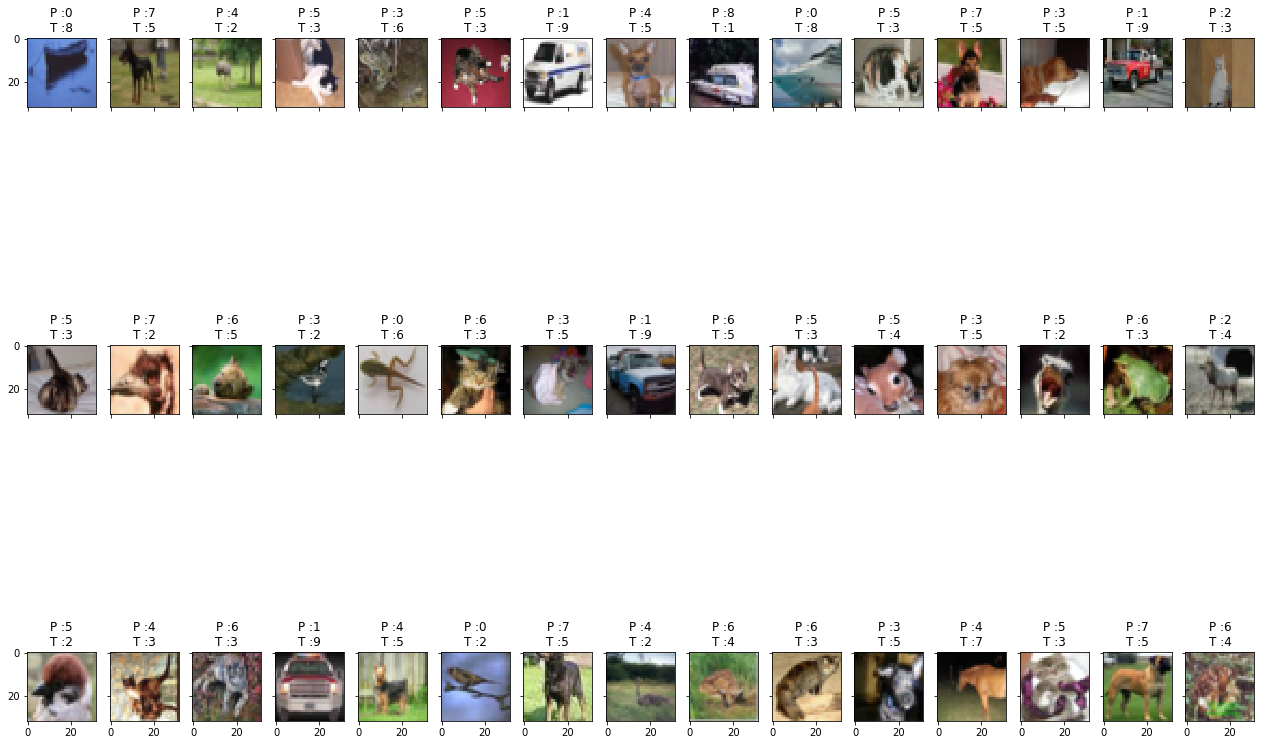

In [0]:
print("Misclassified Images Order by Probability")
show_misclassified_images(Y_pred=Y_pred,Y_true_nor=test_labels,X_test=test_features)

In [0]:
# for i in range(len(gradcam_image_tuple)):
#   filename = str(i)+".jpeg"
#   matplotlib.image.imsave(os.path.join(imagefilepath , filename), gradcam_image_tuple[i])

In [0]:
len(cv_img)

32

## GRADCAM Implementation on misclassified Images

We have already saved misclassified images into google drive and now we need to read them from drive. Before that we will first load the model weights and then generate the heatmap.

**Following steps will be executred for GRADCAM**:

* Load a pre-trained model
* Load an image which can be processed by this model
* Infer the image and get the topmost class index
* Take the output of the final convolutional layer
* Compute the gradient of the class output value w.r.t to L feature maps
* Pool the gradients over all the axes leaving out the channel dimension
* Weigh the output feature map with the computed gradients (+ve)
* Average the weighted feature maps along channels
* Normalize the heat map to make the values between 0 and 1

![grad-cam](https://github.com/amitkayal/akDeepLearningMaster/blob/master/grad_cam.JPG?raw=true)

We will first load the model weights from the layer where output size is atleast 8x8 and this has been done to ensure image viewability.

In [57]:
from google.colab import drive
drive.mount('/content/gdrive')

currentDT = datetime.datetime.now()
print("Current time:", currentDT)


Mounted at /content/gdrive
Current time: 2019-07-08 11:54:53.074670


In [58]:
modelEIP3P2_model.load_weights('/content/gdrive/My Drive/ModelWeightsBackup/EIP3.0_Assignment5.hdf5')
currentDT = datetime.datetime.now()
print("Current time:", currentDT)

Current time: 2019-07-08 11:54:56.511655


In [19]:
modelEIP3P2_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 32, 32, 3)    9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_37 (ZeroPadding2 (None, 38, 38, 3)    0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 16, 16, 64)   9408        zero_padding2d_37[0][0]          
__________________________________________________________________________________________________
bn0 (Batch

In [20]:
last_conv_layer = modelEIP3P2_model.get_layer("stage1_unit1_conv1")
currentDT = datetime.datetime.now()
print("Current time:", currentDT)

Current time: 2019-07-08 11:09:10.418675


## Testing GRADCAM with Original Classified Image - For Single Image![alt text](https://)

In [91]:
!ls -ltr '/content/gdrive/My Drive/ModelWeightsBackup/cifar10/44.jpeg'

-rw------- 1 root root 1457 Jul  2 17:21 '/content/gdrive/My Drive/ModelWeightsBackup/cifar10/44.jpeg'


In [0]:
imagefilepath='/content/gdrive/My Drive/ModelWeightsBackup/cifar10/'
img_path = imagefilepath + '44.jpeg'
# img_path ='/content/gdrive/My Drive/ModelWeightsBackup/cifar10/44.jpeg'
img_path ='/content/gdrive/My Drive/ModelWeightsBackup/cifar10/'

img_path = img_path + '44.jpeg'

In [0]:
import matplotlib
from google.colab.patches import cv2_imshow

kk = matplotlib.pyplot.imread(img_path)

In [0]:
img = image.load_img(img_path, target_size=(32, 32))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

(64,)

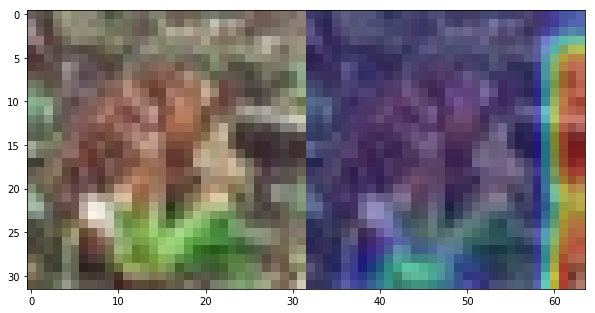

In [122]:
preds = modelEIP3P2_model.predict(x)
class_idx = np.argmax(preds[0])
class_output = modelEIP3P2_model.output[:, class_idx]
last_conv_layer = modelEIP3P2_model.get_layer("stage1_unit1_conv1")
grads = K.gradients(class_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([modelEIP3P2_model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])
pooled_grads_value.shape
for i in range(64):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
# cv2_imshow(img)
# plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# cv2_imshow(superimposed_img)
# plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))


# plt.imshow(superimposed_img)
# cv2.waitKey(0)
vis = np.concatenate((img, superimposed_img), axis=1)

plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))


## Testing GRADCAM with Original Classified Image - For All stored misclassified Images

I have stored 50 misclassified images into my google drive in earlier steps. So here first, I will read all these stored misclassified image file name so that later I can read them and proceed for GRADCAM

In [105]:
imagefilepath='/content/gdrive/My Drive/ModelWeightsBackup/cifar10/'
arr = os.listdir(imagefilepath)
len(arr)

45

Following section retrieve all the file name and concat the google drive path to with file name. This will help me to have absolute path of each misclassified image file.

In [104]:
# r=root, d=directories, f = files
for r, d, f in os.walk(imagefilepath):
    for file in f:
        if ".jpeg" in file:
            print(os.path.join(imagefilepath, file))

/content/gdrive/My Drive/ModelWeightsBackup/cifar10/0.jpeg
/content/gdrive/My Drive/ModelWeightsBackup/cifar10/1.jpeg
/content/gdrive/My Drive/ModelWeightsBackup/cifar10/2.jpeg
/content/gdrive/My Drive/ModelWeightsBackup/cifar10/3.jpeg
/content/gdrive/My Drive/ModelWeightsBackup/cifar10/4.jpeg
/content/gdrive/My Drive/ModelWeightsBackup/cifar10/5.jpeg
/content/gdrive/My Drive/ModelWeightsBackup/cifar10/6.jpeg
/content/gdrive/My Drive/ModelWeightsBackup/cifar10/7.jpeg
/content/gdrive/My Drive/ModelWeightsBackup/cifar10/8.jpeg
/content/gdrive/My Drive/ModelWeightsBackup/cifar10/9.jpeg
/content/gdrive/My Drive/ModelWeightsBackup/cifar10/10.jpeg
/content/gdrive/My Drive/ModelWeightsBackup/cifar10/11.jpeg
/content/gdrive/My Drive/ModelWeightsBackup/cifar10/12.jpeg
/content/gdrive/My Drive/ModelWeightsBackup/cifar10/13.jpeg
/content/gdrive/My Drive/ModelWeightsBackup/cifar10/14.jpeg
/content/gdrive/My Drive/ModelWeightsBackup/cifar10/15.jpeg
/content/gdrive/My Drive/ModelWeightsBackup/cifar1

In [0]:
def GeneratemyGRADCAMWithImage(img_path,gradcam_image_tuple_list):
  img = image.load_img(img_path, target_size=(32, 32))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  
  preds = modelEIP3P2_model.predict(x)
  class_idx = np.argmax(preds[0])
  class_output = modelEIP3P2_model.output[:, class_idx]
  last_conv_layer = modelEIP3P2_model.get_layer("stage1_unit1_conv1")
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([modelEIP3P2_model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  pooled_grads_value.shape
  for i in range(64):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  
  img = cv2.imread(img_path)
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
  vis = np.concatenate((img, superimposed_img), axis=1)
  gradcam_image_tuple_list.append(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))

#   plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))

In [132]:
fullgradcam_image_tuple = [];  # This variable will store all the misclassified images in sorted order

# r=root, d=directories, f = files
for r, d, f in os.walk(imagefilepath):
    for file in f:
        if ".jpeg" in file:
#             print("GradCAM with Original Image:", os.path.join(imagefilepath, file))
            GeneratemyGRADCAMWithImage(img_path=os.path.join(imagefilepath, file),gradcam_image_tuple_list=fullgradcam_image_tuple)
            

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


In [133]:
len(fullgradcam_image_tuple)

45

Following code shows 50 misclassified images along with their heatmap of superimposed image. Each of the orignal image and its corresponding heatmap image are paired together and has been added in the list.

<Figure size 720x432 with 0 Axes>

Text(0.5, 1.0, 'Number 0')

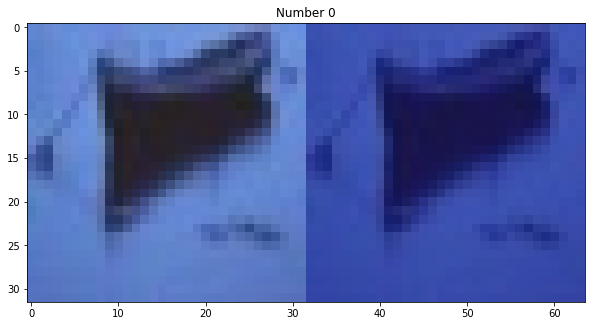

<Figure size 720x432 with 0 Axes>

Text(0.5, 1.0, 'Number 1')

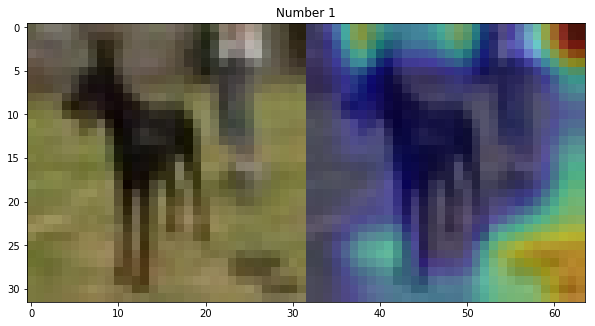

<Figure size 720x432 with 0 Axes>

Text(0.5, 1.0, 'Number 2')

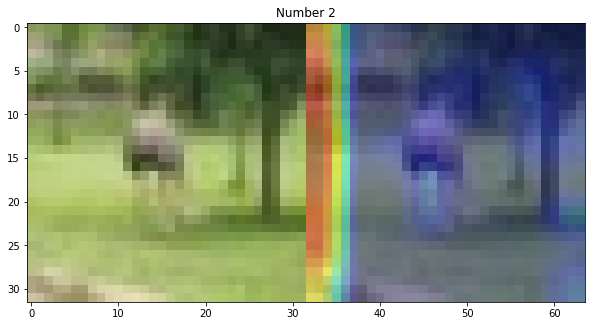

<Figure size 720x432 with 0 Axes>

Text(0.5, 1.0, 'Number 3')

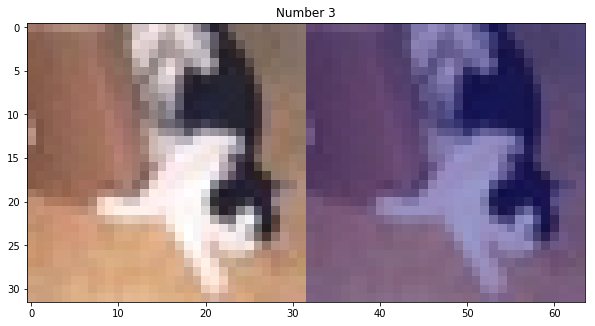

<Figure size 720x432 with 0 Axes>

Text(0.5, 1.0, 'Number 4')

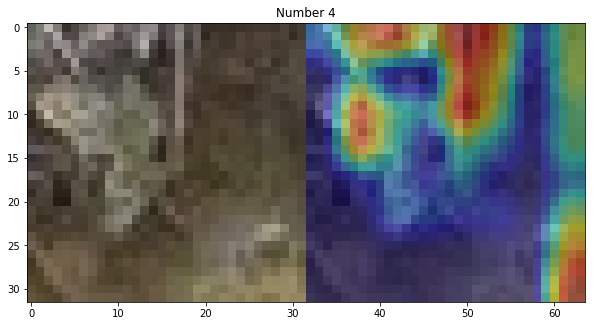

<Figure size 720x432 with 0 Axes>

Text(0.5, 1.0, 'Number 5')

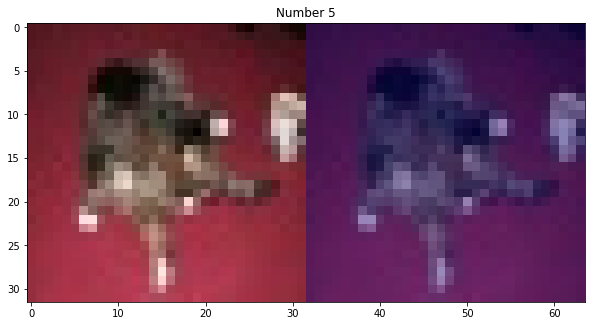

<Figure size 720x432 with 0 Axes>

Text(0.5, 1.0, 'Number 6')

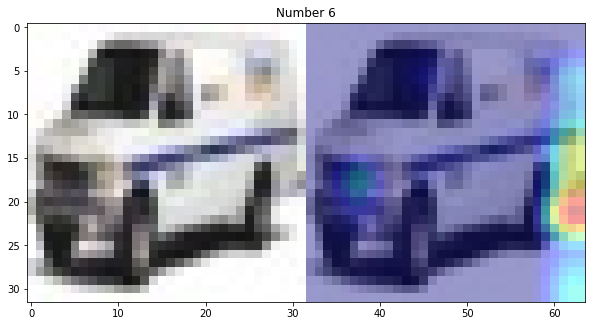

<Figure size 720x432 with 0 Axes>

Text(0.5, 1.0, 'Number 7')

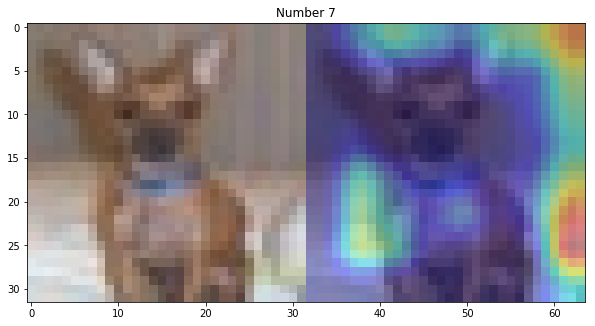

<Figure size 720x432 with 0 Axes>

Text(0.5, 1.0, 'Number 8')

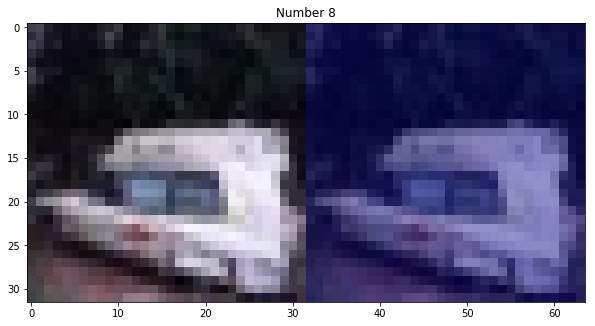

<Figure size 720x432 with 0 Axes>

Text(0.5, 1.0, 'Number 9')

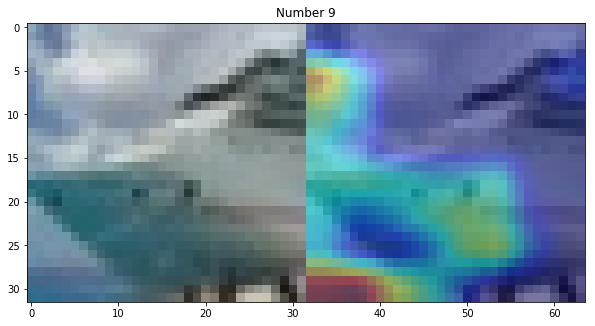

<Figure size 720x432 with 0 Axes>

Text(0.5, 1.0, 'Number 10')

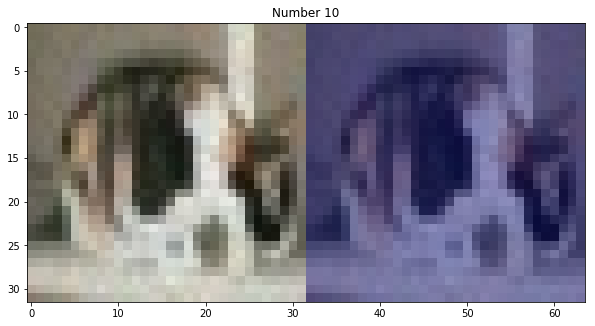

<Figure size 720x432 with 0 Axes>

Text(0.5, 1.0, 'Number 11')

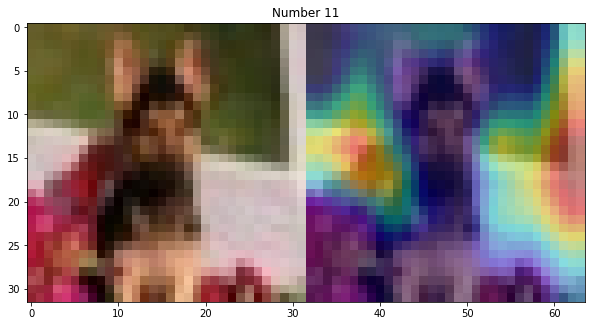

<Figure size 720x432 with 0 Axes>

Text(0.5, 1.0, 'Number 12')

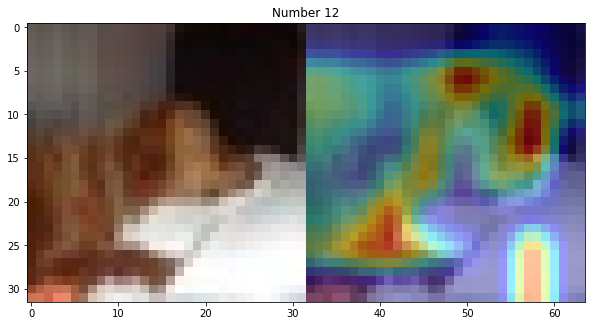

<Figure size 720x432 with 0 Axes>

Text(0.5, 1.0, 'Number 13')

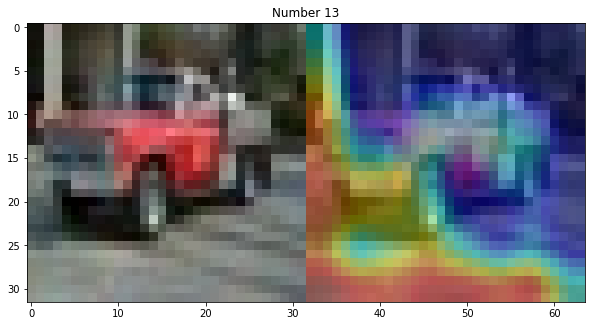

<Figure size 720x432 with 0 Axes>

Text(0.5, 1.0, 'Number 14')

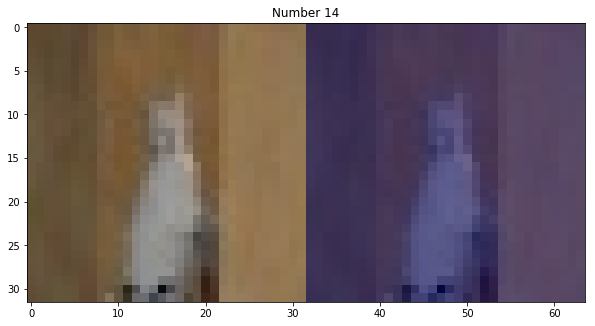

<Figure size 720x432 with 0 Axes>

Text(0.5, 1.0, 'Number 15')

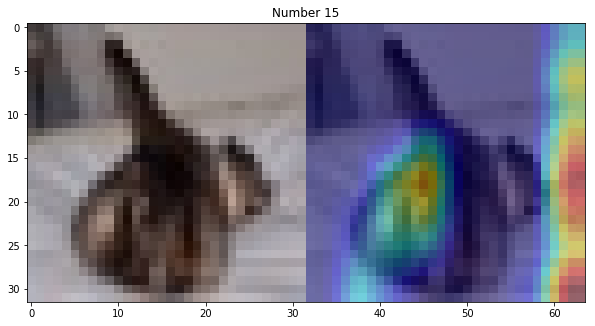

<Figure size 720x432 with 0 Axes>

Text(0.5, 1.0, 'Number 16')

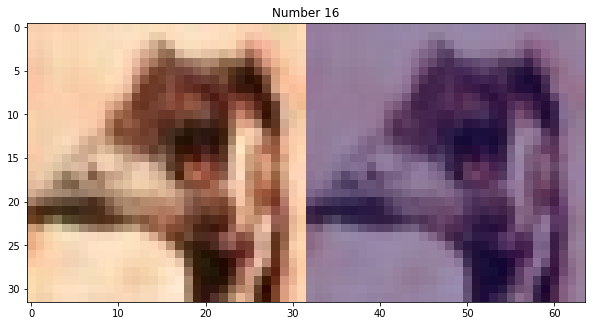

<Figure size 720x432 with 0 Axes>

Text(0.5, 1.0, 'Number 17')

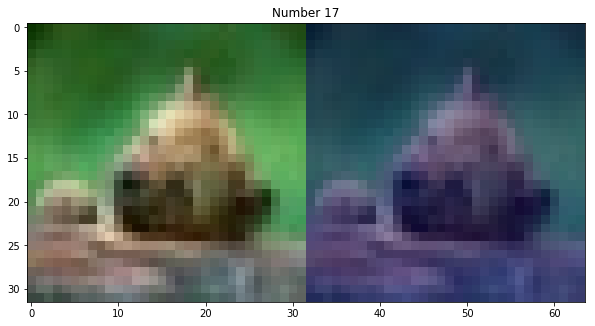

<Figure size 720x432 with 0 Axes>

Text(0.5, 1.0, 'Number 18')

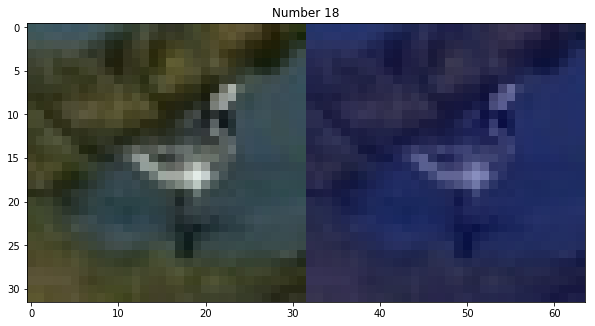

<Figure size 720x432 with 0 Axes>

Text(0.5, 1.0, 'Number 19')

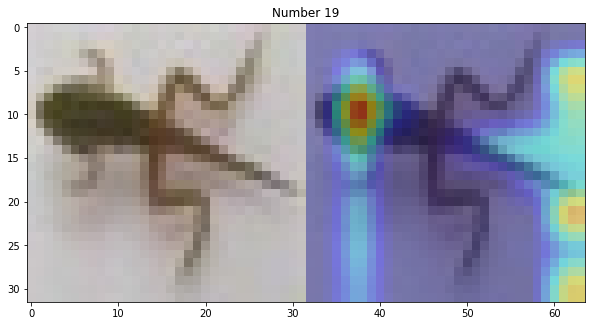

<Figure size 720x432 with 0 Axes>

Text(0.5, 1.0, 'Number 20')

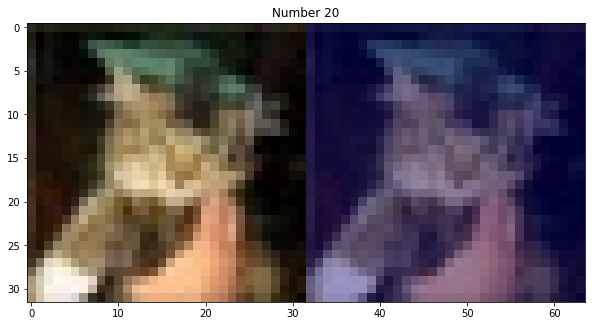

<Figure size 720x432 with 0 Axes>

Text(0.5, 1.0, 'Number 21')

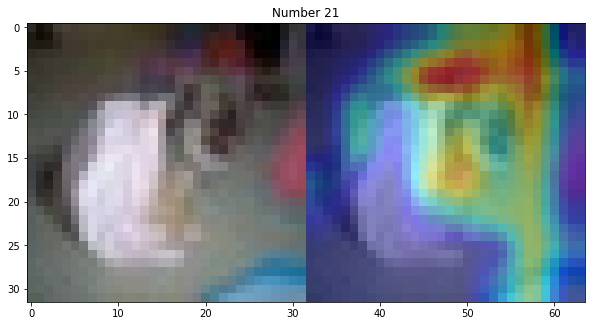

<Figure size 720x432 with 0 Axes>

Text(0.5, 1.0, 'Number 22')

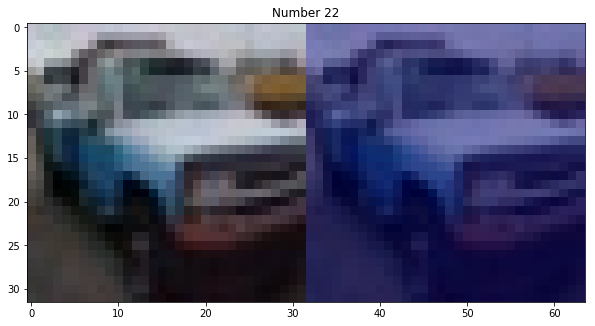

<Figure size 720x432 with 0 Axes>

Text(0.5, 1.0, 'Number 23')

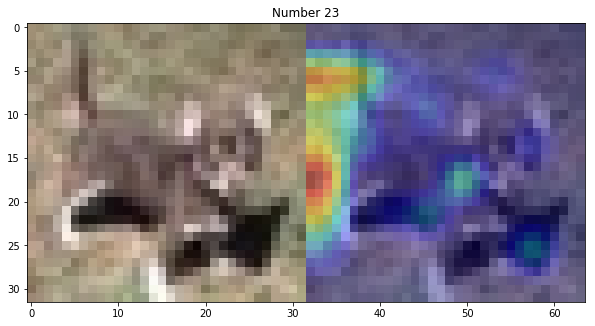

<Figure size 720x432 with 0 Axes>

Text(0.5, 1.0, 'Number 24')

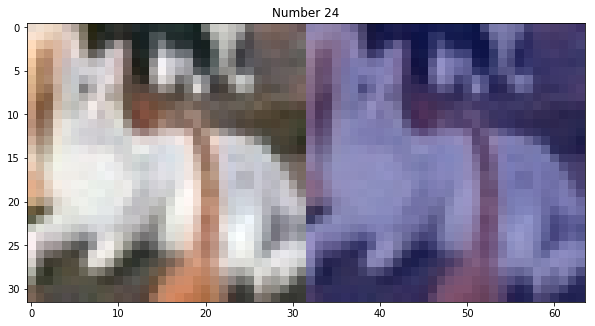

<Figure size 720x432 with 0 Axes>

Text(0.5, 1.0, 'Number 25')

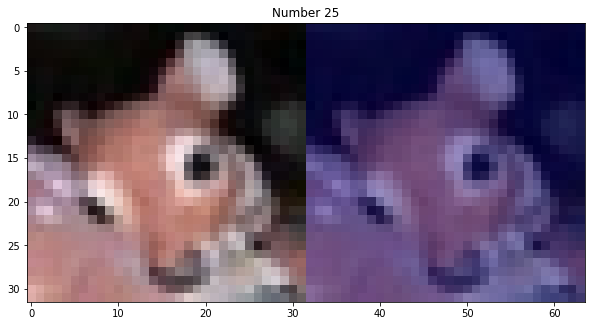

<Figure size 720x432 with 0 Axes>

Text(0.5, 1.0, 'Number 26')

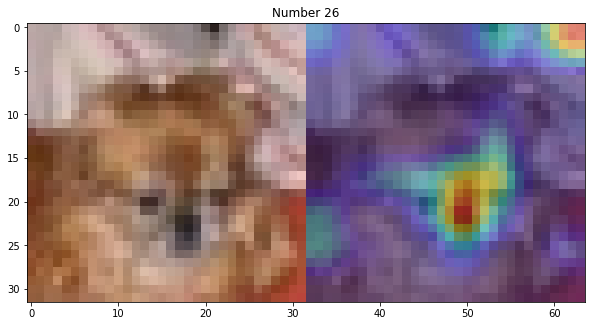

<Figure size 720x432 with 0 Axes>

Text(0.5, 1.0, 'Number 27')

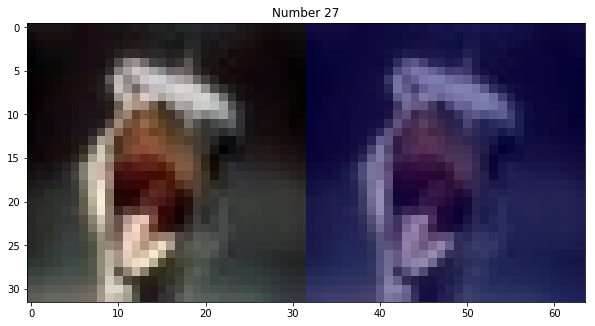

<Figure size 720x432 with 0 Axes>

Text(0.5, 1.0, 'Number 28')

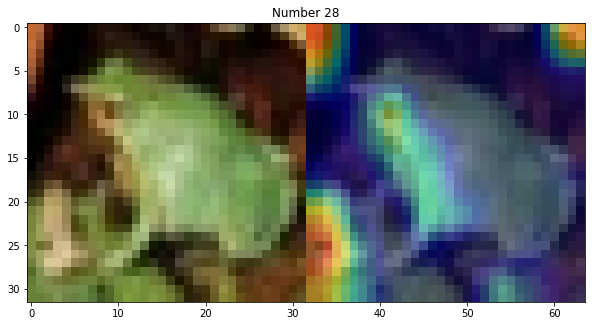

<Figure size 720x432 with 0 Axes>

Text(0.5, 1.0, 'Number 29')

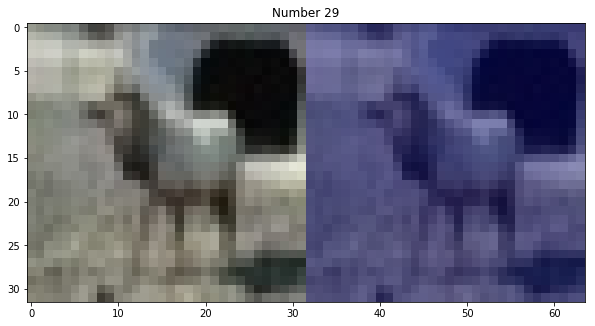

<Figure size 720x432 with 0 Axes>

Text(0.5, 1.0, 'Number 30')

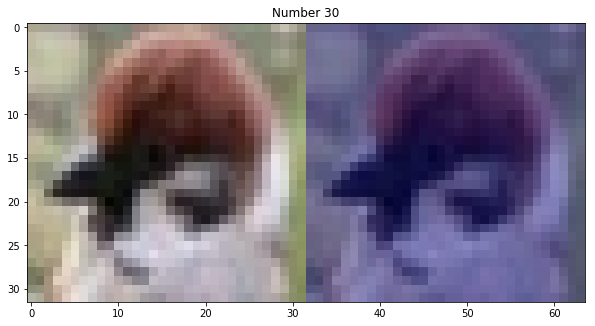

<Figure size 720x432 with 0 Axes>

Text(0.5, 1.0, 'Number 31')

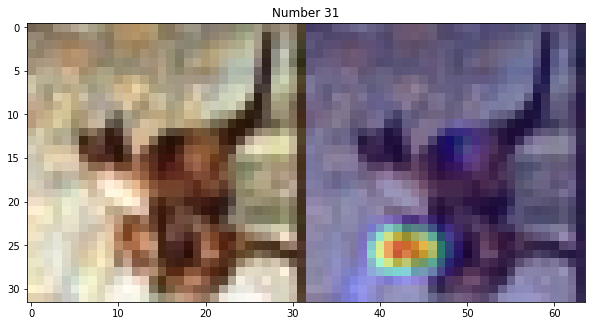

<Figure size 720x432 with 0 Axes>

Text(0.5, 1.0, 'Number 32')

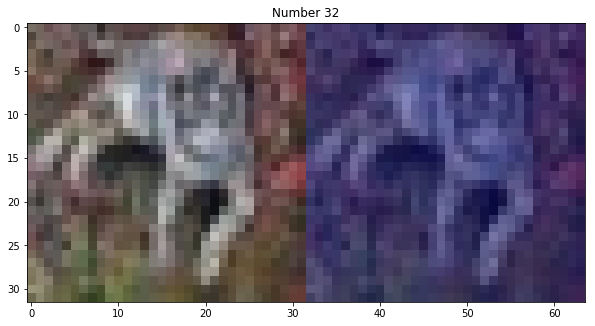

<Figure size 720x432 with 0 Axes>

Text(0.5, 1.0, 'Number 33')

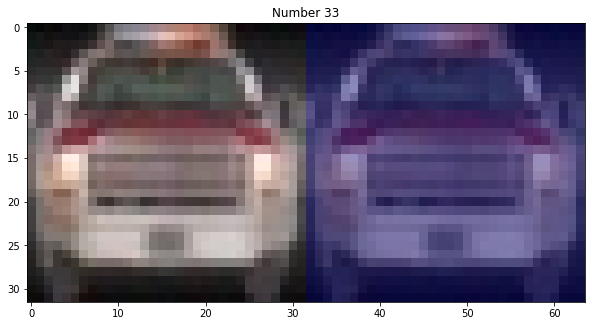

<Figure size 720x432 with 0 Axes>

Text(0.5, 1.0, 'Number 34')

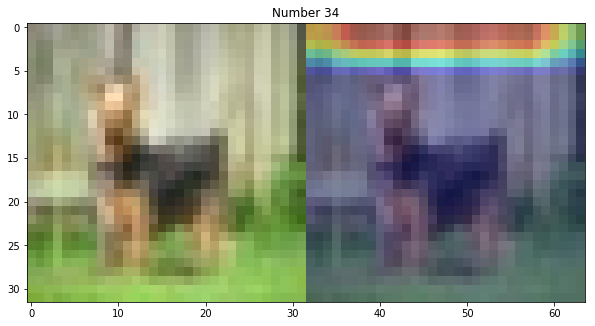

<Figure size 720x432 with 0 Axes>

Text(0.5, 1.0, 'Number 35')

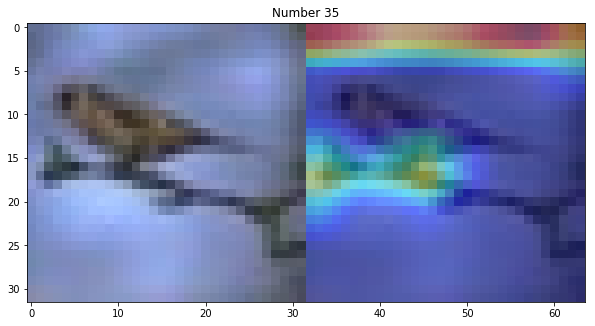

<Figure size 720x432 with 0 Axes>

Text(0.5, 1.0, 'Number 36')

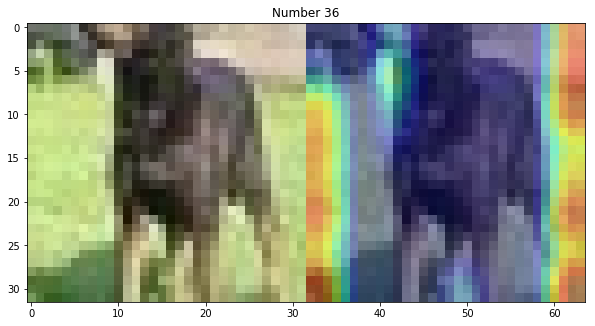

<Figure size 720x432 with 0 Axes>

Text(0.5, 1.0, 'Number 37')

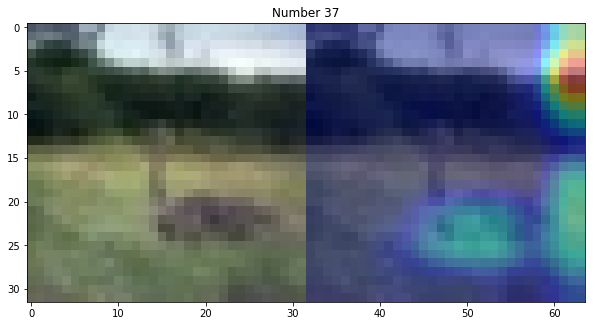

<Figure size 720x432 with 0 Axes>

Text(0.5, 1.0, 'Number 38')

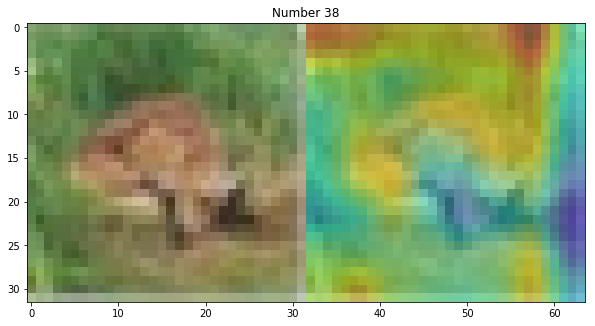

<Figure size 720x432 with 0 Axes>

Text(0.5, 1.0, 'Number 39')

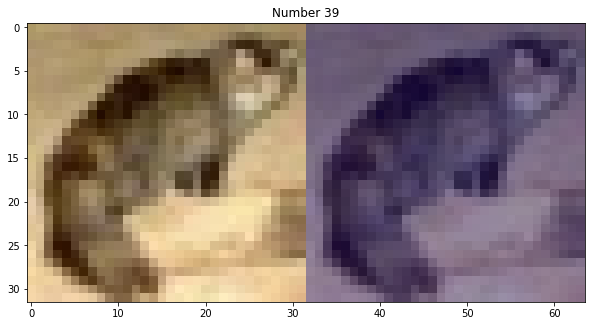

<Figure size 720x432 with 0 Axes>

Text(0.5, 1.0, 'Number 40')

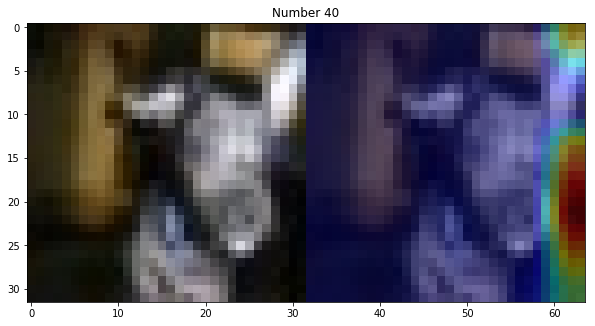

<Figure size 720x432 with 0 Axes>

Text(0.5, 1.0, 'Number 41')

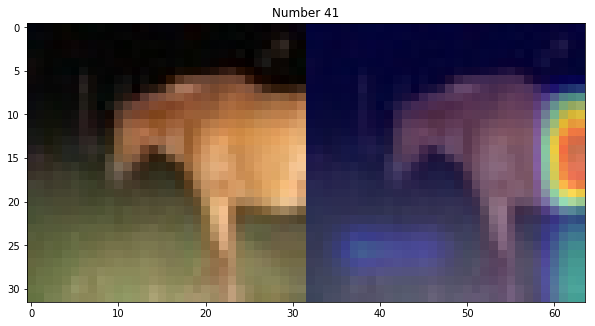

<Figure size 720x432 with 0 Axes>

Text(0.5, 1.0, 'Number 42')

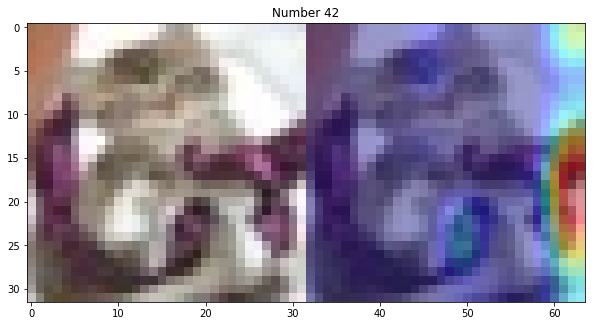

<Figure size 720x432 with 0 Axes>

Text(0.5, 1.0, 'Number 43')

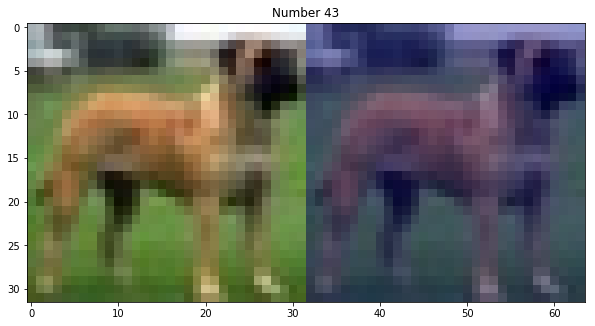

<Figure size 720x432 with 0 Axes>

Text(0.5, 1.0, 'Number 44')

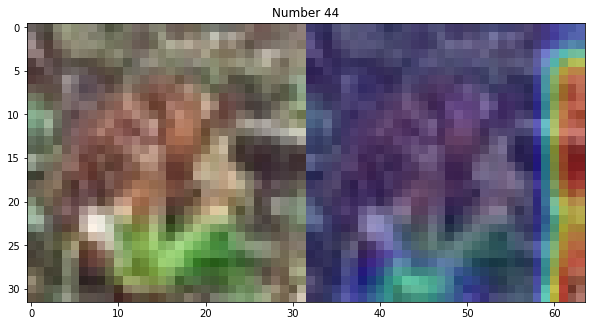

In [139]:
for j in range(len(fullgradcam_image_tuple)):
    img = np.random.normal(size=(20,20))
    plt.figure(1); plt.clf()
    plt.imshow(fullgradcam_image_tuple[j])
    plt.title('Number ' + str(j))
    plt.pause(3)
    
# plt.imshow(fullgradcam_image_tuple[40])